# 聚类

In [17]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

from matplotlib.font_manager import FontProperties # type: ignore
from matplotlib import rcParams # type: ignore

config = {
            "font.family": "serif",
            "font.size": 12,
            "mathtext.fontset": "stix",# matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ["STZhongsong"],# 华文中宋
            "axes.unicode_minus": False # 处理负号，即-号
         }
rcParams.update(config)

from sklearn.cluster import KMeans # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
import category_encoders as ce # type: ignore
from pyod.models.ecod import ECOD # type: ignore
import prince # type: ignore
from yellowbrick.cluster import KElbowVisualizer # type: ignore
from loguru import logger # type: ignore


import sys
sys.path.append("../../../occupational_health_system_v2/")


In [18]:
from utils.data_helper import get_categorical_indicies
from utils.plot_helper import plot_cluster_radar, plot_pca_2d

In [19]:
def get_pca_2d(df, predict):
    """
    建立聚类模型，保留2个主成分
    """
    pca_2d_object = prince.PCA(
        n_components=2,  #  保留两个主成分
        n_iter=3,  # 迭代次数
        rescale_with_mean=True,  # 基于均值和标准差的尺度缩放 
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine="sklearn",
        random_state=42)
    # 模型训练
    pca_2d_object.fit(df)
    # 原数据转换
    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    # 添加聚类预测结果
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d

In [20]:
input_path = "./cache/Chinese_extract_experiment_df_average_freq.csv"
extract_df = pd.read_csv(input_path, header=0, index_col="staff_id")
useful_cols = ["kurtosis_geomean"]
# useful_cols = ["age", "sex", "duration", "NIHL1234", "LAeq", "kurtosis_geomean"]
df_set = extract_df.query("LAeq >= 70")
df_cluster = df_set[useful_cols].copy()
# df_cluster["sex"] = df_cluster["sex"].map({"M":1, "F":0})

In [21]:
# categorical_cols = [
#     useful_cols[i] for i in get_categorical_indicies(X=df_cluster)
# ]
# numerical_cols = list(set(useful_cols) - set(categorical_cols))
# df_cluster = ce.OneHotEncoder(cols=categorical_cols,
#                               use_cat_names=True).fit_transform(df_cluster)

# df_cluster = df_cluster.fillna(df_cluster.mean())
numerical_cols = ["kurtosis_geomean"]
# numerical_cols = ["age", "duration", "NIHL1234", "LAeq", "kurtosis_geomean"]
scaler = StandardScaler()
df_cluster[numerical_cols] = scaler.fit_transform(
    df_cluster[numerical_cols])

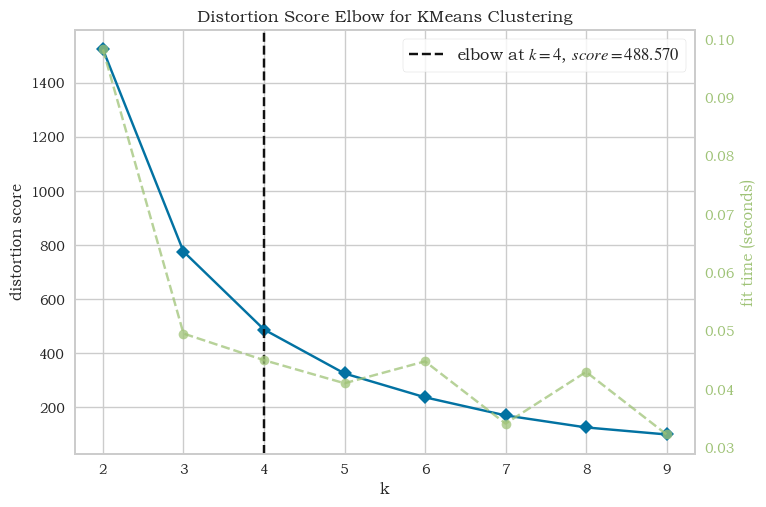

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
# K value recognition
km = KMeans(init="k-means++", random_state=42, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2, 10))
visualizer.fit(df_cluster)
visualizer.show()

In [29]:
n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster)
kmeans.fit(df_cluster)
clusters_predict = kmeans.fit_predict(df_cluster)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# cluster center calculate
class_center_value = {}
for col in numerical_cols:
    feature_no = df_cluster.columns.tolist().index(col)
    original_center_value = cluster_centers[:, feature_no] * df_set[
        col].std() + df_set[col].mean()
    class_center_value[col] = dict(
        zip(["class-" + str(i) for i in range(n_cluster)],
            original_center_value))

df_center = pd.DataFrame.from_dict(class_center_value)
logger.info(f"{df_center}")


# # rader plot
# plot_cluster_radar(model=kmeans,
#                    n_cluster=n_cluster,
#                    cols=df_cluster.columns,
#                    name_dict=dict(zip(df_cluster.columns, df_cluster.columns)),
#                    is_show=True)

# # pca result plot
# pca_2d_object, df_pca_2d = get_pca_2d(df_cluster, clusters_predict)
# plot_pca_2d(df_pca_2d, name="PCA Space", is_show=True)
df_set["labels"] = labels

d:\ProgramFile\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\ProgramFile\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-09-02 15:48:24.897 | INFO     | __main__:<module>:19 -          kurtosis_geomean
class-0         10.016475
class-1        103.714647
class-2        236.060578
class-3         37.732762
C:\Users\Liuhe\AppData\Local\Temp\ipykernel_95228\2084370693.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

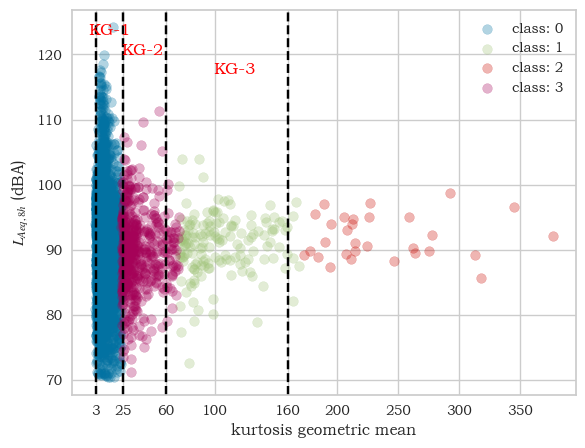

In [50]:

# df_cluster["NIHL"] = df_set["NIHL1234_Y"]
fig, ax = plt.subplots(1, figsize=(6.5, 5))
for label in set(labels):
    df_plot = df_set.query("labels==@label")
    ax.scatter(df_plot.kurtosis_geomean, df_plot.LAeq, alpha=.3, label=f"class: {label}")
ymin, ymax = ax.get_ylim()
ax.vlines(x=3, ymin=ymin, ymax=ymax, colors="black", linestyles="--")
ax.vlines(x=25, ymin=ymin, ymax=ymax, colors="black", linestyles="--")
ax.vlines(x=60, ymin=ymin, ymax=ymax, colors="black", linestyles="--")
ax.vlines(x=160, ymin=ymin, ymax=ymax, colors="black", linestyles="--")
ax.annotate(text="KG-1", xy=(-3, 123), color="red")
ax.annotate(text="KG-2", xy=(24, 120), color="red")
ax.annotate(text="KG-3", xy=(99, 117), color="red")
ax.set_ylim(ymin, ymax)
ax.set_xlabel("kurtosis geometric mean")
ax.set_ylabel("$L_{Aeq,8h}$ (dBA)")
ax.set_xticks([3, 25, 60, 100, 160, 200, 250, 300, 350])
plt.legend(loc="best")
plt.show()

In [49]:
df_set.labels.value_counts()

0    3807
3     503
1     156
2      30
Name: labels, dtype: int64

# 方差检验

In [4]:
from scipy.stats import f_oneway

# 三组样本数据
data_group1 = [-0.98497713, -0.98406264, -0.97766128, -0.96028704, -0.92645669,
       -0.87069302, -0.78752964, -0.67151735, -0.51723268, -0.31928901,
       -0.07235114,  0.22884586,  0.58947204,  1.01457096,  1.50901915,
        2.07747472,  2.72431311,  3.45354765,  4.26873316,  5.17285063,
        6.16817226,  7.25610683,  8.43702702,  9.71008265, 11.07300618,
       12.5219203 , 14.05116077, 15.65313147, 17.31821131, 19.03473459,
       20.7890662 , 22.56578972, 24.34802027, 26.11784366, 27.8568707 ,
       29.54688086, 31.17051532, 32.71196882, 34.15762395, 35.49657342,
       36.72098532]
data_group2 = [-0.98497713, -0.98392233, -0.97653883, -0.95649908, -0.91747921,
       -0.85316342, -0.75725035, -0.62346172, -0.44555404, -0.21733394,
        0.06732147,  0.41443782,  0.82990841,  1.31944849,  1.88853644,
        2.5423389 ,  3.28561681,  4.12260964,  5.05689511,  6.09122289,
        7.22732204,  8.46568422,  9.80532754, 11.2435502 , 12.77568716,
       14.39488888, 16.09194584, 17.85518693, 19.67048189, 21.52137678,
       23.38938553, 25.25444961, 27.09556143, 28.89152701, 30.62182208,
       32.26747744, 33.81191722, 35.24167246, 36.54690198, 37.72167329,
       38.76398449]
data_group3 = [-9.84977131e-01, -9.83572938e-01, -9.73743819e-01, -9.47066848e-01,
       -8.95125675e-01, -8.09518337e-01, -6.81868767e-01, -5.03842841e-01,
       -2.67170326e-01,  3.63252981e-02,  4.14686430e-01,  8.75766865e-01,
        1.42715896e+00,  2.07609743e+00,  2.82933419e+00,  3.69297845e+00,
        4.67229653e+00,  5.77146714e+00,  6.99329007e+00,  8.33885014e+00,
        9.80714412e+00,  1.13946859e+01,  1.30951148e+01,  1.48988441e+01,
        1.67927947e+01,  1.87602717e+01,  2.07810402e+01,  2.28316550e+01,
        2.48860788e+01,  2.69165965e+01,  2.88949907e+01,  3.07939001e+01,
        3.25882406e+01,  3.42565432e+01,  3.57820579e+01,  3.71534980e+01,
        3.83653460e+01,  3.94177048e+01,  4.03157398e+01,  4.10688073e+01,
        4.16893947e+01]

# 执行方差分析
f_statistic, p_value = f_oneway(data_group1, data_group2, data_group3)

# 输出结果
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# 判断是否拒绝零假设
alpha = 0.05
if p_value < alpha:
    print("拒绝零假设，表明至少有一个总体的方差不相等。")
else:
    print("接受零假设，表明各总体的方差相等。")

F-statistic: 0.7886660384329468
P-value: 0.45679172686326475
接受零假设，表明各总体的方差相等。


In [5]:
from scipy.stats import ttest_ind

# 两组样本数据
data_group1 = [-0.98497713, -0.98406264, -0.97766128, -0.96028704, -0.92645669,
       -0.87069302, -0.78752964, -0.67151735, -0.51723268, -0.31928901,
       -0.07235114,  0.22884586,  0.58947204,  1.01457096,  1.50901915,
        2.07747472,  2.72431311,  3.45354765,  4.26873316,  5.17285063,
        6.16817226,  7.25610683,  8.43702702,  9.71008265, 11.07300618,
       12.5219203 , 14.05116077, 15.65313147, 17.31821131, 19.03473459,
       20.7890662 , 22.56578972, 24.34802027, 26.11784366, 27.8568707 ,
       29.54688086, 31.17051532, 32.71196882, 34.15762395, 35.49657342,
       36.72098532]
data_group2 = [-0.98497713, -0.98392233, -0.97653883, -0.95649908, -0.91747921,
       -0.85316342, -0.75725035, -0.62346172, -0.44555404, -0.21733394,
        0.06732147,  0.41443782,  0.82990841,  1.31944849,  1.88853644,
        2.5423389 ,  3.28561681,  4.12260964,  5.05689511,  6.09122289,
        7.22732204,  8.46568422,  9.80532754, 11.2435502 , 12.77568716,
       14.39488888, 16.09194584, 17.85518693, 19.67048189, 21.52137678,
       23.38938553, 25.25444961, 27.09556143, 28.89152701, 30.62182208,
       32.26747744, 33.81191722, 35.24167246, 36.54690198, 37.72167329,
       38.76398449]
data_group3 = [-9.84977131e-01, -9.83572938e-01, -9.73743819e-01, -9.47066848e-01,
       -8.95125675e-01, -8.09518337e-01, -6.81868767e-01, -5.03842841e-01,
       -2.67170326e-01,  3.63252981e-02,  4.14686430e-01,  8.75766865e-01,
        1.42715896e+00,  2.07609743e+00,  2.82933419e+00,  3.69297845e+00,
        4.67229653e+00,  5.77146714e+00,  6.99329007e+00,  8.33885014e+00,
        9.80714412e+00,  1.13946859e+01,  1.30951148e+01,  1.48988441e+01,
        1.67927947e+01,  1.87602717e+01,  2.07810402e+01,  2.28316550e+01,
        2.48860788e+01,  2.69165965e+01,  2.88949907e+01,  3.07939001e+01,
        3.25882406e+01,  3.42565432e+01,  3.57820579e+01,  3.71534980e+01,
        3.83653460e+01,  3.94177048e+01,  4.03157398e+01,  4.10688073e+01,
        4.16893947e+01]

# 执行 t 检验
t_statistic, p_value = ttest_ind(data_group1, data_group2)

# 输出结果
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# 判断是否拒绝零假设
alpha = 0.05
if p_value < alpha:
    print("拒绝零假设，表明两组样本均值存在显著差异。")
else:
    print("接受零假设，表明两组样本均值相等。")

T-statistic: -0.4292333540305476
P-value: 0.668907172701248
接受零假设，表明两组样本均值相等。


In [16]:
from scipy.stats import wilcoxon, ttest_rel

# 两组相关样本数据
data_group1 = [-0.98497713, -0.98406264, -0.97766128, -0.96028704, -0.92645669,
       -0.87069302, -0.78752964, -0.67151735, -0.51723268, -0.31928901,
       -0.07235114,  0.22884586,  0.58947204,  1.01457096,  1.50901915,
        2.07747472,  2.72431311,  3.45354765,  4.26873316,  5.17285063,
        6.16817226,  7.25610683,  8.43702702,  9.71008265, 11.07300618,
       12.5219203 , 14.05116077, 15.65313147, 17.31821131, 19.03473459,
       20.7890662 , 22.56578972, 24.34802027, 26.11784366, 27.8568707 ,
       29.54688086, 31.17051532, 32.71196882, 34.15762395, 35.49657342,
       36.72098532]
data_group2 = [-0.98497713, -0.98392233, -0.97653883, -0.95649908, -0.91747921,
       -0.85316342, -0.75725035, -0.62346172, -0.44555404, -0.21733394,
        0.06732147,  0.41443782,  0.82990841,  1.31944849,  1.88853644,
        2.5423389 ,  3.28561681,  4.12260964,  5.05689511,  6.09122289,
        7.22732204,  8.46568422,  9.80532754, 11.2435502 , 12.77568716,
       14.39488888, 16.09194584, 17.85518693, 19.67048189, 21.52137678,
       23.38938553, 25.25444961, 27.09556143, 28.89152701, 30.62182208,
       32.26747744, 33.81191722, 35.24167246, 36.54690198, 37.72167329,
       38.76398449]
data_group3 = [-9.84977131e-01, -9.83572938e-01, -9.73743819e-01, -9.47066848e-01,
       -8.95125675e-01, -8.09518337e-01, -6.81868767e-01, -5.03842841e-01,
       -2.67170326e-01,  3.63252981e-02,  4.14686430e-01,  8.75766865e-01,
        1.42715896e+00,  2.07609743e+00,  2.82933419e+00,  3.69297845e+00,
        4.67229653e+00,  5.77146714e+00,  6.99329007e+00,  8.33885014e+00,
        9.80714412e+00,  1.13946859e+01,  1.30951148e+01,  1.48988441e+01,
        1.67927947e+01,  1.87602717e+01,  2.07810402e+01,  2.28316550e+01,
        2.48860788e+01,  2.69165965e+01,  2.88949907e+01,  3.07939001e+01,
        3.25882406e+01,  3.42565432e+01,  3.57820579e+01,  3.71534980e+01,
        3.83653460e+01,  3.94177048e+01,  4.03157398e+01,  4.10688073e+01,
        4.16893947e+01]

# 执行 Wilcoxon 秩和检验
statistic, p_value = wilcoxon(data_group3, data_group2)
statistic, p_value = ttest_rel(data_group1, data_group3)

# 输出结果
print("Wilcoxon statistic:", statistic)
print("P-value:", p_value)

# 判断是否拒绝零假设
alpha = 0.05
if p_value < alpha:
    print("拒绝零假设，表明两组相关样本之间存在显著差异。")
else:
    print("接受零假设，表明两组相关样本之间没有显著差异。")

Wilcoxon statistic: -7.708753260452694
P-value: 1.970353709563622e-09
拒绝零假设，表明两组相关样本之间存在显著差异。


In [ ]:
from scipy.stats import chi2_contingency

# 创建一个包含分类数据的二维表格（列联表）
# 例如，这里是一个 2x2 的表格
observed = [data_group1,
            data_group2]

# 执行卡方检验
chi2_stat, p_val, dof, expected = chi2_contingency(observed)

# 输出结果
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

# 判断是否拒绝零假设
alpha = 0.05
if p_val < alpha:
    print("拒绝零假设，表明两组分类数据之间存在显著差异。")
else:
    print("接受零假设，表明两组分类数据之间没有显著差异。")